In [1]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [2]:
print(librosa.__version__)
print(soundfile.__version__)
print(sklearn.__version__)

0.10.1
0.12.1
1.3.2


In [3]:
def extract_feature(file_name, mfcc, chroma, mel):
    # Open the sound file using the soundfile library
    with soundfile.SoundFile(file_name) as sound_file:
        # Read the sound file data and sample rate
        X = sound_file.read(dtype="float32")
        sample_rate = sound_file.samplerate
        
        # Compute the short-time Fourier transform (stft) of the audio signal
        stft = np.abs(librosa.stft(X))
        
        # Initialize an empty array to store the extracted features
        result = np.array([])

        # If the 'mfcc' flag is True, extract Mel-frequency cepstral coefficients (MFCC)
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))
        
        # If the 'chroma' flag is True, extract chroma feature
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
            result = np.hstack((result, chroma))
        
        # If the 'mel' flag is True, extract mel spectrogram feature
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)
            result = np.hstack((result, mel))
    
    # Return the concatenated array of extracted features
    return result


In [4]:
#Emotions in the RAVDESS dataset
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}
#Emotions to observe - using only sub-part of dataset
observed_emotions=['calm','happy','fearful','disgust','sad','angry','surprised']

In [5]:
for file in glob.glob(r'C:\Users\USER\Python Files\emotion-dataset\Actor_*[0-9]*\*'):
  file_name = os.path.basename(file)
  print(file_name)

03-01-01-01-01-01-01.wav
03-01-01-01-01-02-01.wav
03-01-01-01-02-01-01.wav
03-01-01-01-02-02-01.wav
03-01-02-01-01-01-01.wav
03-01-02-01-01-02-01.wav
03-01-02-01-02-01-01.wav
03-01-02-01-02-02-01.wav
03-01-02-02-01-01-01.wav
03-01-02-02-01-02-01.wav
03-01-02-02-02-01-01.wav
03-01-02-02-02-02-01.wav
03-01-03-01-01-01-01.wav
03-01-03-01-01-02-01.wav
03-01-03-01-02-01-01.wav
03-01-03-01-02-02-01.wav
03-01-03-02-01-01-01.wav
03-01-03-02-01-02-01.wav
03-01-03-02-02-01-01.wav
03-01-03-02-02-02-01.wav
03-01-04-01-01-01-01.wav
03-01-04-01-01-02-01.wav
03-01-04-01-02-01-01.wav
03-01-04-01-02-02-01.wav
03-01-04-02-01-01-01.wav
03-01-04-02-01-02-01.wav
03-01-04-02-02-01-01.wav
03-01-04-02-02-02-01.wav
03-01-05-01-01-01-01.wav
03-01-05-01-01-02-01.wav
03-01-05-01-02-01-01.wav
03-01-05-01-02-02-01.wav
03-01-05-02-01-01-01.wav
03-01-05-02-01-02-01.wav
03-01-05-02-02-01-01.wav
03-01-05-02-02-02-01.wav
03-01-06-01-01-01-01.wav
03-01-06-01-01-02-01.wav
03-01-06-01-02-01-01.wav
03-01-06-01-02-02-01.wav


In [6]:
def load_data(test_size=0.2):
    x, y = [], []
    for file in glob.glob(r'C:\Users\USER\Python Files\emotion-dataset\Actor_*[0-9]*\*'):
        file_name = os.path.basename(file)
        emotion = emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        feature = extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(emotion)

    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

In [7]:
# Split the dataset
x_train, x_test, y_train, y_test = load_data(test_size=0.25)

In [8]:
#Get the shape of the training and testing datasets
print((x_train.shape[0], x_test.shape[0]))

(1008, 336)


In [9]:
#Get the number of features extracted
print(f'Features extracted: {x_train.shape[1]}')

Features extracted: 180


In [10]:
#Initialize the Multi Layer Perceptron Classifier
model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

In [11]:
#Training the model
model.fit(x_train,y_train)

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

In [12]:
model.score(x_train, y_train)

0.8382936507936508

In [13]:
#Predict for the test set
y_pred=model.predict(x_test)

#Calculate the accuracy of our model
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)

#Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 62.80%


In [14]:
y_pred[:10]

array(['fearful', 'sad', 'happy', 'happy', 'disgust', 'disgust',
       'fearful', 'happy', 'calm', 'calm'], dtype='<U9')

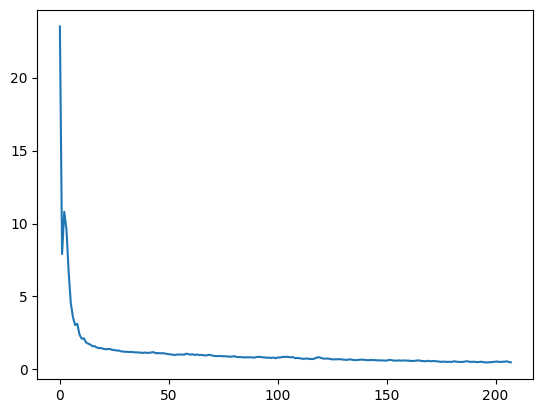

In [15]:
# Plotting graph for MLPClassifier

loss_values = model.loss_curve_
plt.plot(loss_values)
plt.show()

In [16]:
model1=MLPClassifier(alpha=0.001, batch_size=128, hidden_layer_sizes=(1000, 1000, 600, 400), learning_rate='adaptive', max_iter=500)

#Training the model
model1.fit(x_train,y_train)

model1.score(x_train, y_train)

0.998015873015873

In [17]:
#Predict for the test set
y_pred1=model1.predict(x_test)

#Calculate the accuracy of our model
accuracy1=accuracy_score(y_true=y_test, y_pred=y_pred1)

#Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy1*100))

Accuracy: 66.67%


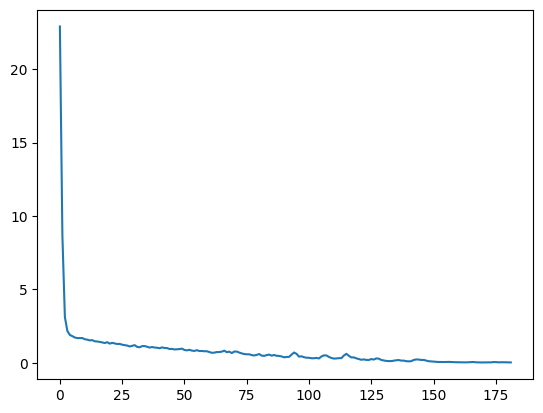

In [18]:
# Plotting graph for MLPClassifier

loss_values1 = model1.loss_curve_
plt.plot(loss_values1)
plt.show()

In [19]:
# Saving the tokenizer and the model:

import pickle

pickle.dump(model1, open(r'C:\Users\USER\Python Files\emotion_classification-model.pkl', 'wb'))